In [13]:
import pickle
import numpy as np
pickle_in = open("dataset_pickle\X_bot.pickle","rb")
X_bot = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\X_top.pickle","rb")
X_top = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_multimodal.pickle","rb")
y = pickle.load(pickle_in)


# X_top = X_top/255.0
# X_bot = X_bot/255.0

print(X_top.shape)
print(X_bot.shape)

(1920, 100, 100, 1)
(1920, 100, 100, 1)


In [14]:
# from sklearn.model_selection import train_test_split
# x_train_comp = np.stack((X_top, X_bot), axis=4)
# x_train, x_test, y_train, y_test = train_test_split(x_train_comp, y, test_size = 0.2)

# #print(x_train.shape)
# #print(x_test.shape)

# x_train_top = x_train[:,:,:,:,0]
# x_test_top= x_test[:,:,:,:,0]

# x_train_bot = x_train[:,:,:,:,1]
# x_test_bot = x_test[:,:,:,:,1]

In [15]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
#Setup Distrbuited training
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

2 Physical GPUs, 2 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy
from keras.layers.merge import concatenate
import datetime

tf.random.set_seed(42)

num_classes = 6

numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []

top_input = Input(X_top.shape[1:4])
bot_input = Input(X_bot.shape[1:4])

for train,test in kfold.split((X_top,X_bot), y):
    with strategy.scope():      #Enables multi-gpu
        # a layer instance is callable on a tensor, and returns a tensor
        top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top_input)
        bot = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(bot_input)
        z = concatenate([top, bot])
        top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(z)
        top = MaxPooling2D(pool_size=(1, 4), strides=(2))(top)
        top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
        top = MaxPooling2D(pool_size=(1, 2), strides=(2))(top)
        top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
        top = MaxPooling2D(pool_size=(2, 2), strides=(2))(top)
        top = Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu')(top)
        top = MaxPooling2D(pool_size=(1, 2), strides=(2))(top)
        top = Flatten()(top)
        y = Dense(6, activation='softmax')(top)

        lr_change = ReduceLROnPlateau(monitor="val", factor=0.5, patience=3, min_lr=0.000)
        early_stopping = EarlyStopping(monitor='val', min_delta=0.01, patience=10, mode='min')

        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        callbacks = [lr_change,early_stopping,tensorboard_callback]

        model = Model(inputs=[top_input,bot_input], outputs=y)
        model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.001),           
                metrics=['accuracy'])
        history = model.fit([X_top[train],X_bot[train]], y[train], batch_size=16, epochs=100,callbacks=callbacks)
        scores = model.evaluate([X_top[test],X_bot[test]], y[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
#model.summary()

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [20]:
# history = model.fit(X, y, batch_size=16, epochs=200, validation_split=0.2,callbacks=callbacks)
history = model.fit([x_train_top,x_train_bot], y_train, batch_size=16, epochs=100,callbacks=callbacks,
                    validation_data=([x_test_top,x_test_bot],y_test))
# history = model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 14 all-reduces with algorithm = hierarchical_copy, num_packs = 1
84/84 [==============================] - 6s 22ms/step - loss: 2.8914 - accuracy: 0.1964 - val_loss: 1.2527 - val_accuracy: 0.5260
Epoch 2/100
84/84 [==============================] - 1s 14ms/step - loss: 1.0708 - accuracy: 0.6052 - val_loss: 0.8147 - val_accuracy: 0.6910
Epoch 3/100
84/84 [==============================] - 1s 15ms/step - loss: 0.7164 - accuracy: 0.6934 - val_loss: 0.6847 - val_accuracy: 0.7257
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 0.5542 - accuracy: 0.7605 - val_loss: 0.6387 - val_accuracy: 0.7205
Epoch 5/100
84/84 [==============================] - 1s 15ms/step - loss: 0.4763 - accuracy: 0.8053 - val_loss: 0.5168 - val_accuracy: 0.7674
Epoch 6/100
84/84 [==============================] - 1s 15ms/step - loss: 0.5357 - accuracy:

60/60 - 1s - loss: 0.0972 - accuracy: 0.9797
60/60 [==============================] - 0s 7ms/step - loss: 0.0972 - accuracy: 0.9797


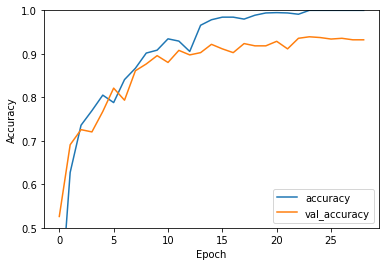

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate([X_top,X_bot], y , verbose=2)
preds = model.evaluate([X_top,X_bot], y,verbose=1, sample_weight=None)

In [23]:
model.save("models\model_early_fusion2.h5")
print("model saved")

model saved


In [24]:
from keras.models import load_model
# load model
model = load_model('models\model_early_fusion2.h5')
# summarize model.
#model.summary()

In [27]:
# evaluate the model
import pickle
pickle_in = open("dataset_pickle\X_bot_user.pickle","rb")
X_test_bot = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\X_top_user.pickle","rb")
X_test_top = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_multimodal_user.pickle","rb")
y_test = pickle.load(pickle_in)

# X_test_bot = X_test_bot/255.0
# X_test_top = X_test_top/255.0

score = model.evaluate([X_test_top,X_test_bot], y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

8/8 - 0s - loss: 51.2239 - accuracy: 0.1667
accuracy: 16.67%


In [22]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,rankdir='LR')

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
y_pred = model.predict(X_test)
rounded_labels=np.argmax(y_pred, axis=1)
print(rounded_labels.shape)
confusion = confusion_matrix(y_test, rounded_labels)

(240,)


In [11]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[35  0  0  0  3  2]
 [ 0 31  1  0  7  1]
 [ 0  0 40  0  0  0]
 [ 0  0  0 40  0  0]
 [ 1  5  0  0 34  0]
 [ 1  0  0  0  1 38]]


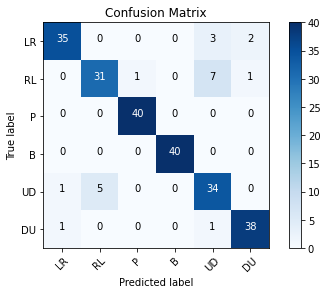

In [12]:
import itertools
Classes = ["LR", "RL", "P", "B", "UD", "DU"]
plot_confusion_matrix(cm=confusion,title='Confusion Matrix', classes=Classes)
#plot.savefig('plot_confusion_matrix.png')